<a href="https://colab.research.google.com/github/americanthinker/vector_search_applications_PUBLIC/blob/master/1_Data_Preprocessing_Week1_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Week 1: Vector Search Applications w/ LLMs.  Authored by Chris Sanchez.

# Project 1.1

# Overview

Welcome to Week 1 of this course!  Over the course of two weeks we will build an application that utilizes both keyword and vector search as core components of a Retrieval Augmented Generation (RAG) system integrated with a Generative AI LLM. At a high level we will work with the following tech stack to build out each system component:

* [**SentenceTransformers**](https://www.sbert.net/): to convert text into vectors as well as rerank returned resuls
* [**OpenSearch**](https://www.opensearch.org): will act as both our keyword and vector database
* [**Llamaindex**](https://www.llamaindex.ai): will be our "glue" code which provides much of the heavy lifting
* OpenAI ChatGPT-3.5-Turbo: Our LLM of choice for answer synthesis and generation
* [**Streamlit**](https://streamlit.io/): We'll wrap up everything together for display to users through a Streamlit UI



<div>
<img src="https://www.python.org/static/community_logos/python-logo-master-v3-TM-flattened.png" style="text-align:center" width="300"/>
<img src="https://huggingface.co/spaces/sentence-transformers/README/resolve/main/sbertLogo.png" width="180"/>
<img src="https://d2908q01vomqb2.cloudfront.net/ca3512f4dfa95a03169c5a670a4c91a19b3077b4/2021/07/12/opensearch_logo_1000x500.png" width="200"/>
</div>
<div>
<img src="https://d1tlzifd8jdoy4.cloudfront.net/wp-content/uploads/2023/03/eyecatch-llamdaindex.png" width="200"/>
<img src="https://blogs.sap.com/wp-content/uploads/2023/08/1681142315open-ai-logo-1.png" width="250"/>
<img src="https://streamlit.io/images/brand/streamlit-logo-primary-colormark-darktext.svg" width="200"/>
</div>

# Problem
LLMs are an amazing technology but they do have their limitations.  How do we feed relevant information to a model that was trained on text from over two years ago?  
Below are the pain points that a RAG system addresses:

- LLMs are static, i.e. they are “frozen in time” and lack up-to-date information. It is not feasible to update their massive training datasets on a regular basis.
- They lack domain-specific knowledge - LLMs are trained for generalized tasks, meaning they do not know your company’s private data.
- They function as “black boxes” - it’s not easy to understand which sources an LLM was considering when they arrived at their conclusions.

Citation: Pinecone Blog -- ["Retrieval Augmented Generation (RAG): The Solution to GenAI Hallucinations"](https://www.pinecone.io/learn/retrieval-augmented-generation/)

# Approach
As a reminder we will divide the approach to building this system into four parts over two weeks-

#### Week One
* Part 1 (THIS NOTEBOOK):
  * Data ingest and preprocessing
  * Convert text into vectors
* Part 2:
  * Index data on OpenSearch database
  * Benchmark retrieval results  

#### Week Two
* Part 3:
  * Add a reranker to the mix (new benchmark)
  * Integrate with ChatGPT-Turbo
* Part 4:
  * Benchmark overall system
  * Display results in Streamlit



Let's get cracking!

## Install libraries for this notebook

In [1]:
#visualization tool for displaying long load/processing times
!pip install tqdm --quiet
#data processing
!pip install pandas --quiet
#workhorse for converting text into embeddings/vectors
!pip install sentence-transformers==2.2.2 --quiet
#data framework for LLM applications
!pip install llama-index==0.8.41 --quiet
#logging output
!pip install loguru==0.7.0 --quiet
#easy way to access predefined envars
!pip install python-dotenv

## Download preprocessing file (helper code) from public repo

In [3]:
!curl -o preprocessing.py https://raw.githubusercontent.com/americanthinker/vector_search_applications_PUBLIC/master/preprocessing.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12776  100 12776    0     0  49378      0 --:--:-- --:--:-- --:--:-- 49519


## Download data from publicly accessible s3 bucket
Total download size should be about 25 MB

In [1]:
!curl -o impact_theory_data.json https://vector-search-applications-data.s3.us-west-2.amazonaws.com/impact_theory_updated_Nov1.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.4M  100 25.4M    0     0  13.6M      0  0:00:01  0:00:01 --:--:-- 13.6M


In [226]:
#standard libraries
import json
import os
import time
from collections import defaultdict
from typing import List, Dict, Tuple, Callable
from math import ceil

#external libraries
import pandas as pd
import numpy as np
from torch import cuda
from tqdm.notebook import tqdm
from preprocessing import FileIO

## Step 1 -->  Import YouTube/Podcast Transcripts

The hard part of this project i.e. collecting the data and wrangling it into an acceptable format has already been completed for you.  Yes, there is value in completing that step yourself, not the least of which is gaining a better understanding of the nuances and format of the data.  But, given our compressed time window, we will focus our efforts on the actual search application components of this project.

### The Data
The data - **385** podcast episodes to be exact - we will use for this project is a collection of transcribed podcast/youtube episodes of <a href="https://www.youtube.com/@TomBilyeu" target="_blank">The Impact Theory</a>.  From the About section of Impact Theory:
<h4 style='text-align: center;'><em>"Impact Theory™ is a weekly interview show that explores the mindsets of the world's highest achievers to learn their secrets to success.</em></h4>
<h4 style='text-align: center;'><em>Hosted by Quest Nutrition co-founder Tom Bilyeu, Impact Theory is designed to give people the tools and knowledge they need to unlock their potential and impact the world."</em></h4>

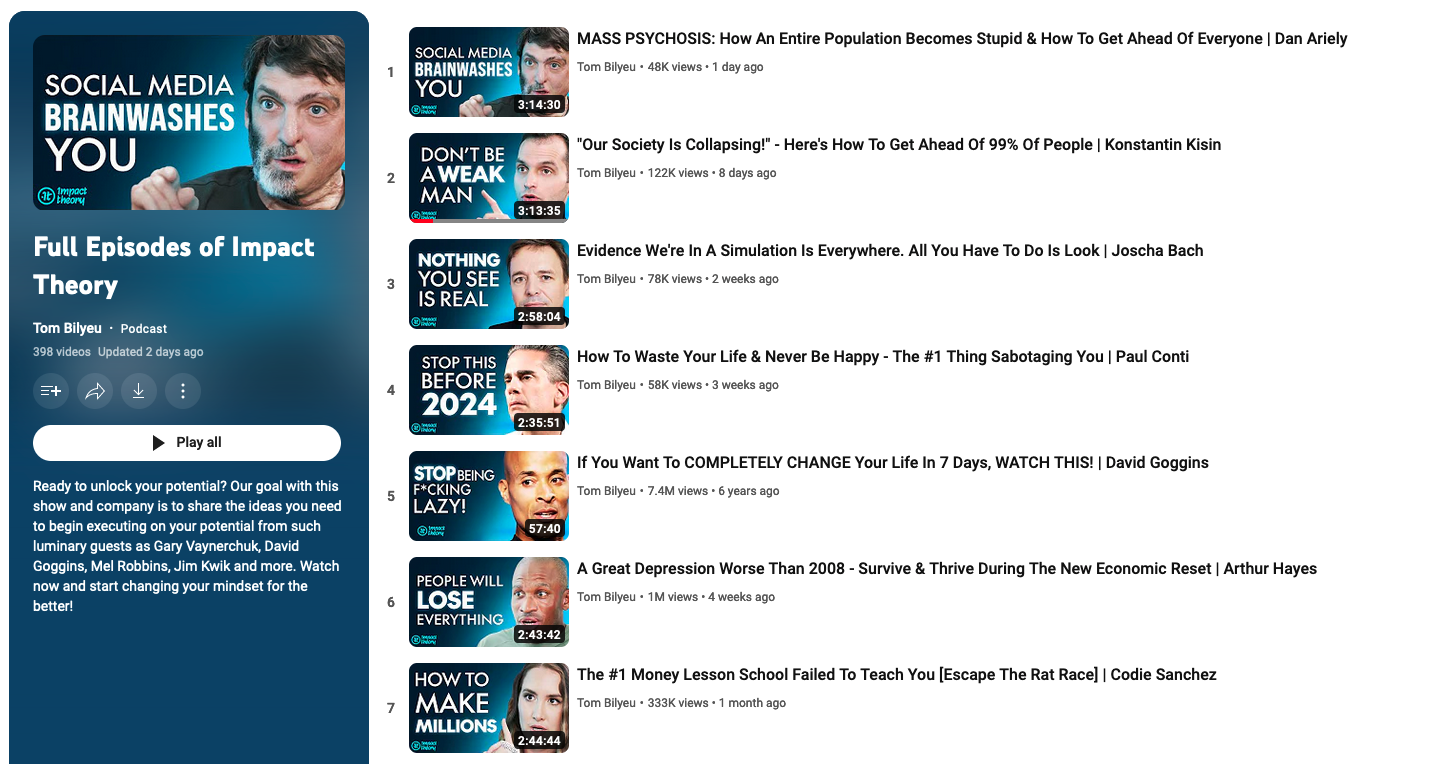

Throughout this course I will refer to the data as "YouTube" episodes or "podcast" episodes.  The reason for this is that the show is setup like a podcast and is released as a podcast, but it's also available on YouTube.  The episodes for this course were pulled from the podcast audio files and transcribed using the OpenAI open source Whisper model.  The transcriptions were then linked back to each episode using a unique **video_id**.  

### Import Data

Assuming you've already downloaded the data from the publicly available s3 bucket earlier, follow the instructions below to import the data and make it available in this notebook's namespace.  The below instructions assume you are running this notebook on Google Colab.  

  
**If you are not running this notebook on Colab, you'll need to readjust your data filepaths.**

In [6]:
#root folder on Google Colab is: /content/
root_folder = '/content/'
data_file = 'impact_theory_data.json'
data_path = os.path.join(root_folder, 'impact_theory_data.json')
data_path

'/content/impact_theory_data.json'

In [3]:
#should see 385 unique podcast entries
with open(data_path) as f:
    data =  json.load(f)
print(f'Total # of episodes: {len(data)}')

Total # of episodes: 385


### Data Review

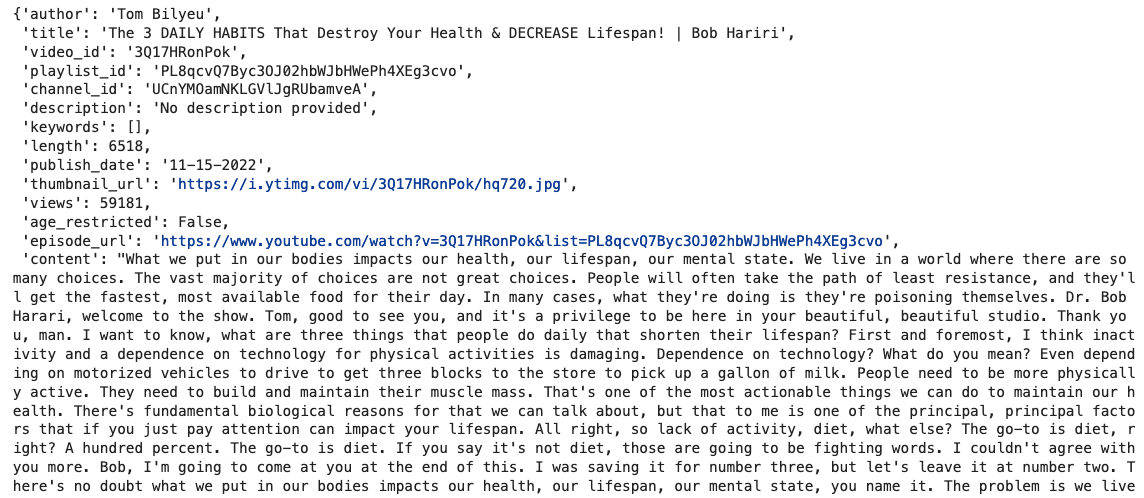

By taking a peek at the data we can see that each entry contains episode metadata (title, author, episode length, etc.) as well as the transcript of the episode located in the `content` field.  It may not jump out at you now, but we'll soon see that the `video_id` is one of the most important fields of the bunch, because it provides us with a unique identifier for each podcast episode.  Below is a down and dirty metadata glossary:

#### Metadata Glossary
- **author**: Episode author.
- **title**: Episode title.
- **video_id**: Unique identifier for each individual episode.
- **playlist_id**: Unique identifier for entire playlist of episodes.  All episodes in this dataset will have the same playlist_id.
- **channel_id**: REMOVE FROM DATA
- **description**: Summary of the episode.
- **keywords**: REMOVE FROM DATA
- **length**: Length of the episode in total seconds.
- **publish_date**: Date the episode was published to the YouTube channel.
- **thumbnail_url**: Hyperlink to the associated image of the YouTube episode.
- **views**: Number of views of this YouTube episode.
- **age_restricted**: REMOVE FROM DATA
- **episode_url**: Hyperlink to the episode on YouTube.
- **content**: The full transcript of the episode. 

The star of this show is the `content` field, as this is the field that we will be searching over when retrieving relevant documents.  The episode metadata, however, is also very useful.  Metadata can be used to boost searches, filter searches, improve answer synthesis, and several other creative use cases.  A good example of a metadata use case is using the `thumbnail_url` to associate an image with each search result in the User Interface as well as using the `episode_url` as a clickable link within the search result to take the end-user directly to the episode of interest. 

The `content` field of the example above is truncated for ease of viewing in the notebook. Let's get some statistics on the length of the content for each episode. We'll count (roughly) the number of words in each episode by splitting on whitespace.

#### Content Length Stats

In [4]:
lens = [len(d['content'].split()) for d in data]
df = pd.DataFrame(lens, columns=['Lengths'])
df.describe()

Lengths
count    385.000000
mean   12884.654545
std     7741.439730
min     1819.000000
25%     7891.000000
50%     9899.000000
75%    16860.000000
max    48502.000000

In [5]:
mean_word_count = ceil(np.mean(lens))
token_to_word_ratio = 1.3
approx_token_count = ceil(mean_word_count * token_to_word_ratio)
print(f'The mean word count is about {mean_word_count} words, which corresponds to a rough token count of {approx_token_count}')

The mean word count is about 12885 words, which corresponds to a rough token count of 16751


#### Tokens

LLMs operate on tokens. Tokens are words or sub-parts of words, so the word "texting" might be broken into two tokens `text` and `##ing`. A [750 word document will be about 1000 tokens](https://www.anyscale.com/blog/num-every-llm-developer-should-know), in other words the token to word ratio is roughly 1.3 tokens = 1 word. (For a detailed discussion, see the section titled **Preprocessing and Chunking** in the Week 1 Course Content).

Given that the mean token count for each of our podcast episodes is over 16K tokens, we'll need a way to chunk our content so that we can effectively embed the transcript into several meaningful embeddings as opposed to one embedding for the entire transcript. 

## Step 2 -->  Sentence Splitting and Chunking (LlamaIndex)

### Chunking:
As addressed above, the open source embedding models that we will be working with have a `max_sequence_length` parameter far less than 16K tokens. In order to effectively process the content of our podcast episodes, we'll need to decide on a **Chunking Strategy**. There are several ways to split a document into chunks, but the one we'll cover for this course involves the following steps, as outlined in the associated diagram below:

1. Gather documents.  In our case we're considering a single Impact Theory episode to be a "document".
2. Decide how to split your documents.  When working with text documents, a good starting strategy is to split on sentence boundaries.  This decision at the very least, prevents input text from randomly being cut off in the middle of a paragraph.  We'll use an excellent piece of code written by [LlamaIndex](https://github.com/run-llama/llama_index/blob/main/llama_index/text_splitter/sentence_splitter.py) namely, the `SentenceSplitter` class.
3. Pick a chunk size (refer to the detailed discussion in the course notes).  Given that the `all-miniLM-L6-v2` was trained on documents no greater than 256 tokens in length, we'll start with 256.  A chunk size of 256 strikes a good balance between information granularity and not blowing up the embedding space.
4. After splitting, a single episode will be broken up into `n` number of chunks, depending on the length of the episode.  Each of those chunks, however, should be no longer than 256 tokens.  Those chunks can then be passed through our embedding model as inputs and converted into vector representations.
5. The final step is combining the text chunks, their associated vectors, and the original metadata into a single dictionary (one for each chunk), in preparation for follow-on indexing on OpenSearch. 

![Chunking Strategy]( 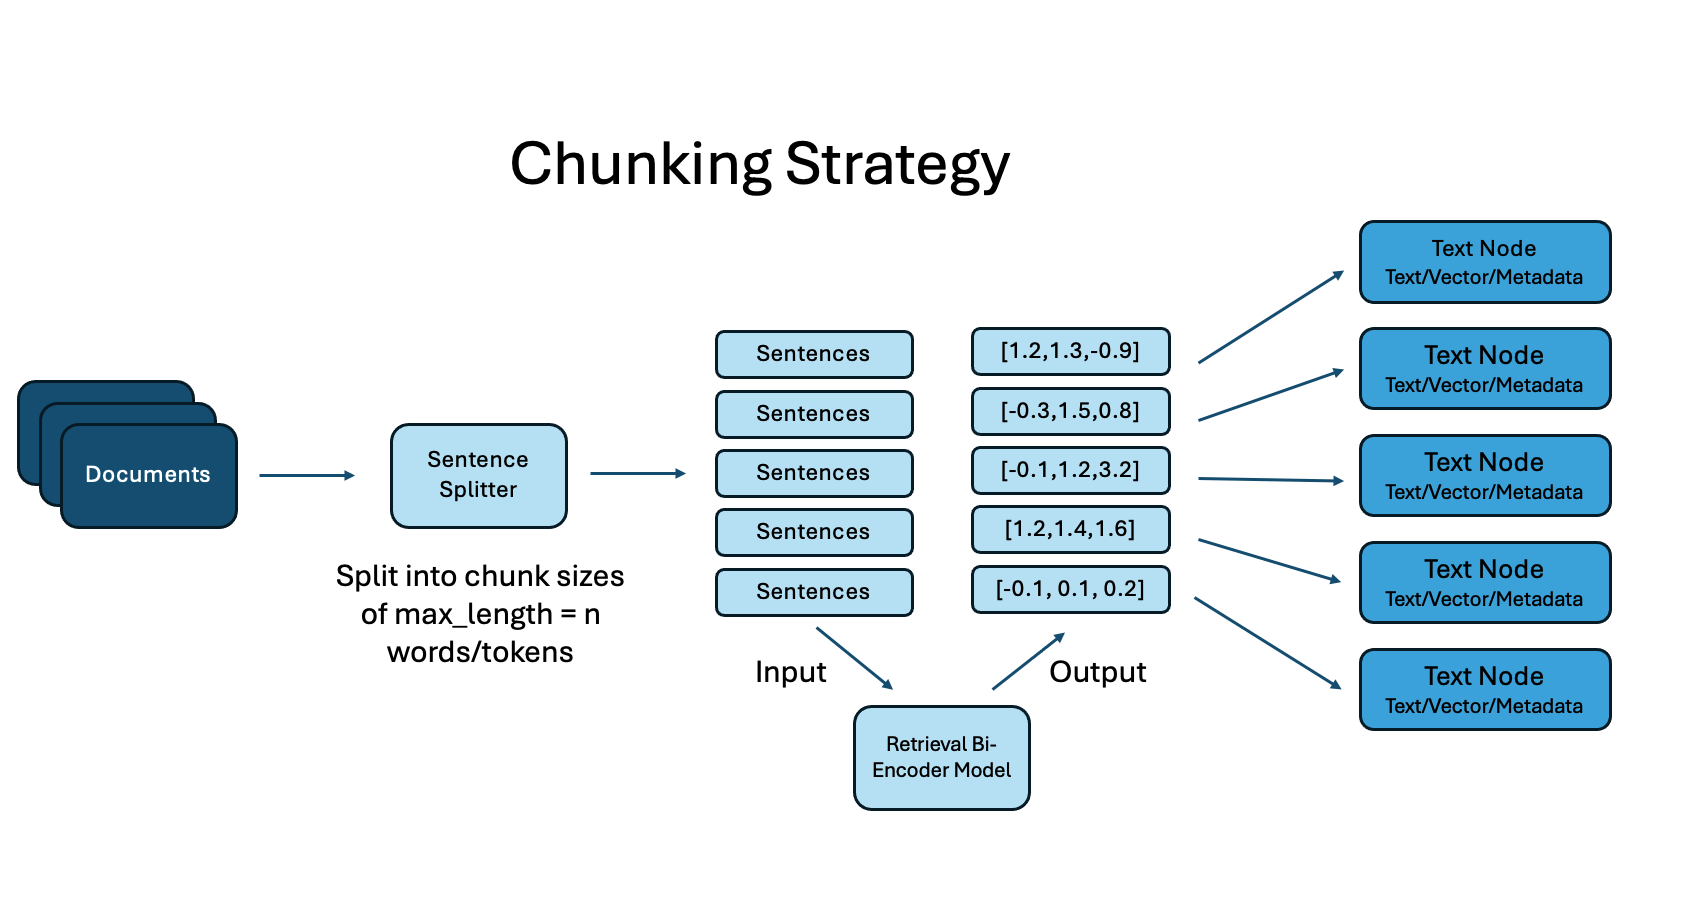)

#### Docstring for Llamaindex's SentenceSplitter Class

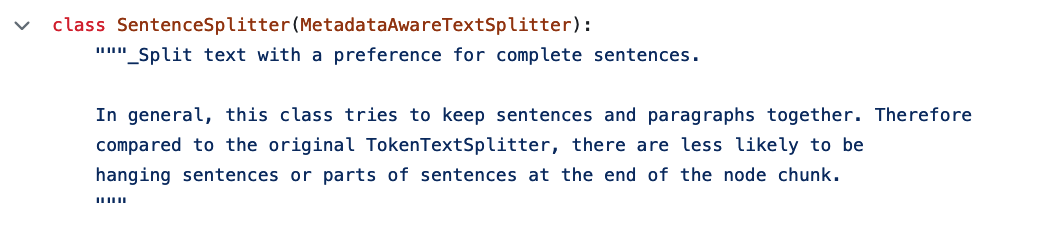

The primary args that we'll review here for the SentenceSplitter are: 
- `chunk_size`
- `tokenizer`
- `chunk_overlap`

**A quick note here**: it's not necessary to pass in a tokenizer function into SentenceSplitter.  The default tokenizer under the hood, which is primarily used to count tokens to match the chunk size, is the `tiktoken` GPT-2 tokenizer.  Technically, in the interest of precision it's probably a good practice to count tokens using the same tokenizer as the one your embedding model of choice was trained with.  I'll also bring up a point of nuance right now (might as well get it over with &#128512;), the model we'll be using for creating embeddings (the Retriever) will most likely be different from the LLM that we'll be using for Question Answering.  In other words, the way that tokens will be counted will be slightly different.  In practice, this doesn't matter much (at least for the use cases that I've worked with).  I bring it up now though as we are going to be chunking our data into `chunk_size` tokens.  We'll take a look at a comparison of a few approaches below. 

In [223]:
from transformers import AutoTokenizer
import tiktoken # bad ass tokenizer library for use with OpenAI LLMs 
from llama_index.text_splitter import SentenceSplitter #one of the best on the market

#instantiate tokenzier for our embedding model of choice
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#instantiate tokenizer for use with ChatGPT-3.5-Turbo
encoding = tiktoken.encoding_for_model('gpt-3.5-turbo')

#set chunk size and instantiate three SentenceSplitters 
chunk_size = 256
default_txt_splitter = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=0)
allmini_txt_splitter = SentenceSplitter(chunk_size=chunk_size, tokenizer=tokenizer.encode, chunk_overlap=0)
gpt35_txt_splitter   = SentenceSplitter(chunk_size=chunk_size, tokenizer=encoding.encode, chunk_overlap=0)

In [224]:
#get a small subset of the data
content_subset = [d['content'] for d in data[:10]]

#generate splits for each tokenizer
default_splits = [default_txt_splitter.split_text(episode) for episode in tqdm(content_subset)]
gpt35_splits   = [gpt35_txt_splitter.split_text(episode) for episode in tqdm(content_subset)]
allmini_splits = [allmini_txt_splitter.split_text(episode) for episode in tqdm(content_subset)]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (47702 > 512). Running this sequence through the model will result in indexing errors


In [225]:
#comparison of the three approaches
print(f'Token split lengths - DEFAULT:\n{list(map(len, default_splits))}\n')
print(f'Token split lengths - GPT-3.5-TURBO:\n{list(map(len, gpt35_splits))}\n')
print(f'Token split lengths - all-MiniLM-L6:\n{list(map(len, allmini_splits))}')

Token split lengths - DEFAULT:
[200, 82, 177, 143, 21, 166, 152, 215, 190, 10]

Token split lengths - GPT-3.5-TURBO:
[200, 83, 178, 144, 21, 168, 152, 215, 190, 10]

Token split lengths - all-MiniLM-L6:
[222, 89, 194, 157, 23, 182, 168, 240, 207, 11]


Analysis shows there is minimal difference between the default GPT-2 tokenizer and GPT-3.5 tokenizer (not suprising).  There is a fair amount of difference in comparison to the `all-MiniLM` tokenizer.  My guess is that the GPT tokenizers have a larger vocabulary of whole word tokens, meaning they likely have less sub-word tokens in their vocabulary than their `all-MiniLM` counterpart, and therefore have a lower token-per-sentence count.  Given the speed of the [tiktoken](https://github.com/openai/tiktoken) library (see the `Performance` section) and because in practice the encoding scheme doesn't play a huge role in Retriever performance, we'll stick with the GPT-3.5 encoding for now.  

*** **Future benchmarks that we'll be running will depend on using the `gpt-3.5-turbo` encoding so be sure to use it when creating your embedding datasets later in this notebook.**  
**YOU'VE BEEN WARNED!** 😈

# Assignment 1.1 - Chunking the Data

#### *Write a function that will split the original podcast episodes into chunks of chunk_size = n*
<details>
  <summary>Click to reveal helper instructions</summary>
  
#### INSTRUCTIONS
1. Iterate over the `corpus` of podcast episodes
2. Extract the `content_field` value from each episode
3. Split the `content` field using the `text_splitter.split_text` method
4. Return a list of lists of chunked texts
</details>

**#HINT:** This function can be written in a single line of code

In [23]:
def split_contents(corpus: List[dict],
                   text_splitter: SentenceSplitter,
                   content_field: str='content'
                   ) -> List[List[str]]:
    '''
    Given a corpus of "documents" with text content, this function splits the
    content field into chunks sizes as specified by the text_splitter.

    Example
    -------
    corpus = [
            {'title': 'This is a cool show', 'content': 'There is so much good content on this show. \
              This would normally be a really long block of content. ... But for this example it will not be.'}, 
            {'title': 'Another Great Show', 'content': 'The content here is really good as well.  If you are \
              reading this you have too much time on your hands. ... More content, blah, blah.'}
           ]
           
    output = split_contents(data, text_splitter, content_field="content")
    
    output >>> [['There is so much good content on this show.', 'This would normally be a really long block of content.', \
                 'But for this example it will not be'], 
                ['The content here is really good as well.', 'If you are reading this you have too much time on your hands.', \
                 'More content, blah, blah.']
                ]
    '''
    
    ########################
    # START YOUR CODE HERE #
    ########################


### Analysis of Episode Length

In [153]:
#helper function to capture the lengths of each split

def get_split_lengths(splits: List[List[str]], column_name: str='Split Lengths') -> pd.DataFrame:
    '''
    Given a list of text splits, returns the length of each split
    in a pandas DataFrame.
    '''
    lengths = list(map(len, splits))
    return pd.DataFrame(lengths, columns=[column_name])

In [154]:
gpt35_splits = [gpt35_txt_splitter.split_text(episode) for episode in tqdm(contents)]

  0%|          | 0/385 [00:00<?, ?it/s]

In [156]:
import plotly.express as px

column_name = 'Split Lengths'

#replace None with the output from the split_contents function
df = get_split_lengths(None, column_name=column_name)

#reverse the order of the episode # to correctly show left to right chronological order
df.index = sorted(list(df.index), reverse=True)

#plot results
fig = px.bar(df, x=df.index, y=column_name, labels={'index':'Episode #', column_name:'Length in Tokens'}, title='Episode Length (tokens) over Time', height=600)
fig.show()

<details>
  <summary>Draw your own conclusions and then Click here</summary>  
There is a clear trend of episodes increasing in length over time.  One can also see that there is an occasional episode that is significantly shorter in length than other episodes of the same time period.  My thought here is that those are truncated episodes, meaning the author, for whatever reason, did not publish the episode in its entirety. The conclusions we can draw from this simple analysis will not affect the way we build our IR system, however, it's always a good idea to become as familiar with your data/domain as much as possible. 
</details>

## Step 3 -->  Encode Text Chunks as Vectors

#### SentenceTransformers

In 2019, about a year after the original BERT model was released, Nils Reimers and Iryna Gurevych dropped a bomb on the NLP community by open sourcing their research on sentence-level embeddings: [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf).  Their accompanying [sentence-transformers](https://www.sbert.net/) library provided NLP practioners with access to state of the art sentence-level embeddings, and remains a powerful option even today (for a detailed discussion see Course notes). 

#### Model Selection
Model selection is kind of a big deal...For starters we are going to use the `all-MiniLM-L6-v2` variant because it's actually quite good out of the box and it also happens to be very fast (at embedding creation).  [Click here](https://www.sbert.net/docs/pretrained_models.html) for a comprehensive list of available pretrained SentenceTransformers (these are also all availabel through the HuggingFace API):

![Pretrained Model List]( 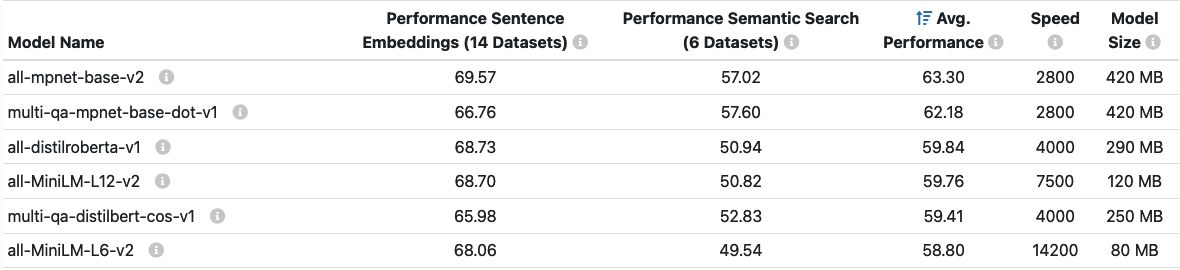)

This model card provides great information at a glance and allows practitioners to do a comprehensive comparison of available models.  If you're on the website and you click on the shaded grey info circle, it will show additional details about each model.  Becuase we are building an Information Retrieval system that utilizes Semantic Search, we're going to be most interested in the following numbers:
- Performance Semantic Search
- Speed (encoding speed)
- Model Size

Right off the bat you can see that the `all-MiniLM-L6-v2` is the worst performing of the group, so why use it?  If you look at the **Speed** column you'll note that this model is almost 7x times faster than the two highest performing models.  The numbers in the Speed column represent number of sentences encoded per second, ("sentences" here referring to any chunk of text longer than a single word but less than the `max_sequence_length` of the model). For comparison I ran a quick experiment pitting the `all-MiniLM` against the `all-mpnet-base-v2`.  After chunking the Impact Theory episodes it took the `all-MiniLM` 33 seconds to encode all 385 episodes, whereas the `all-mpnet` took over 5 minutes.  That's almost 10x longer! Given the small amount of data we are using for this course, those numbers don't matter very much, but it's a point to consider if you are working with a much larger corpus.

Ultimately model selection comes down to your use case and the trade-off between performance and latency (and to a degree the size of the model on disk).  Later on in the course you'll have the chance to experiment with different embedding models to see how they can boost retrieval performance in your system.  When you're ready for that step head on over to the [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) where you can check out the latest state of the art embedding models.  The `all-MiniLM-L6-v2` ranks a lowly 47th on the Retrieval task.  

Let's take the `all-MiniLM` out for a spin before the next assignment....

In [157]:
from sentence_transformers import SentenceTransformer

#define the model you want to use
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_path)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

A quick glance at the model configuration shows us the following information:
- **Max sequence length:** (or input length) is 256 tokens.  The underlying model is a BERT model, so technically we could adjust this parameter to 512 tokens, however, because the model was trained on inputs of no greater than 256 tokens, we'll keep the default.
- **The embedding dimension:** (i.e. the output vector) is 384 dimensions.  Make sure not to confuse the `max_sequence_length` with the embedding dimesion.  The maximum sequence length is the maximum number of input tokens the model will process before truncating any text over that limit, and the emnbedding dim is the length of the output vector which always remains fixed in size.
- **Pooling Layer:** this model uses the mean token pooling strategy for creating a fixed sized embedding from all vector outputs (see class notes for details). 

#### Model Encoding

![sbert_docstring]( 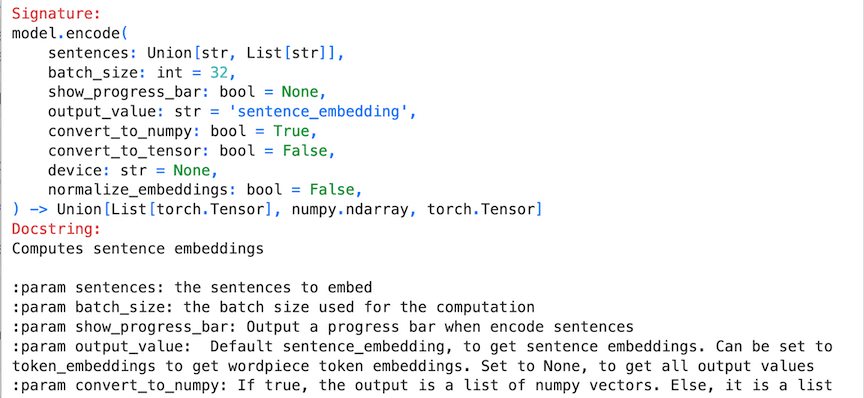)

We are going to work solely with the `model.encode` method for our text embedding creation.  Their is a surprising amount of work being done under the hood with this function to include word tokenization, batching, GPU device setting, etc. If you really must know, feel free to review [lines 111 - 202 in the Github repo](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/SentenceTransformer.py).  Here's a few notes for our course:
- `sentences`: accepts either a single string or a list of strings.  Very convenient.  This will allow us to enter all of the chunks from a single podcast episode at once, allowing for efficient processing and episode integrity.
- `batch_size`: under the hood the list of sentences in the input is batched.  Default is 32, so if your input was 128 sentences, then the model would translate that into 4 batches for processing.  DataLoader not needed.  Assuming you are using Google Colab for this notebook, use the default setting.
- `convert_to_numpy`: default output is a numpy array.  There will be no need to convert to Pytorch tensors.  However, because OpenSearch does not accept the np.array data type, we'll want to eventually convert these arrays into Python lists.
- `device`: set to either cpu or GPU (`"cuda:0"`) for single GPU.  If `None` the function will handle this step for you and choose the fastest option! 

Let's take a quick tour of how this function works in practice.

In [183]:
#create sample sentences
text1 = "I ran down the road"
text2 = "I ran down the street"
text3 = "I ran down the lane"
text4 = "I ran down the avenue"
text5 = "I ran over to the house"

In [200]:
road_sentences = [text1, text2, text3, text4, text5]
road_vectors = model.encode(road_sentences)

In [201]:
road_vectors.shape, road_vectors

((5, 384),
 array([[ 0.01464685,  0.0561101 ,  0.02563804, ..., -0.0925348 ,
         -0.04195407, -0.04409865],
        [ 0.04675803,  0.07742155,  0.04562965, ..., -0.0812416 ,
         -0.10972543, -0.02546268],
        [ 0.06553327,  0.0994243 , -0.04012905, ...,  0.00221833,
         -0.0342925 , -0.04802397],
        [ 0.05736331,  0.08300827,  0.00926694, ..., -0.10420122,
         -0.10806054, -0.03672466],
        [ 0.06660569,  0.03724336,  0.02164606, ..., -0.01440302,
         -0.1198651 ,  0.00423094]], dtype=float32))

As mentioned earlier the output vector dimension is 384 for this model, so we should expect to see 5 vectors of length 384 dims.  
Given that all of these vectors are of the same length we can compare them in vector space using a cosine simlarity function.  
The sentence-transformer's `semantic_search` function allows us to compare a single text (or multiple) to multiple texts and ranks them based on distance in vector space.  

In [216]:
from sentence_transformers.util import semantic_search

# we need to reencode our texts here with pytorch tensors to work with the semantic_search function
tensors = model.encode(road_sentences, convert_to_tensor=True)

# we'll set our query to the first sentence
query = model.encode(text1, convert_to_tensor=True)

#compare our query with all of the other sentences, including itself (expect to see a cossim value of 1)
results = semantic_search(query_embeddings=query, corpus_embeddings=tensors)[0]
for result in results:
    print(f'Score: {round(result["score"],3)} - {road_sentences[result["corpus_id"]]}')

Score: 1.0 - I ran down the road
Score: 0.905 - I ran down the street
Score: 0.823 - I ran down the lane
Score: 0.805 - I ran down the avenue
Score: 0.673 - I ran over to the house


Here we can see that the word `road` is most semantically meaningful to itself, followed by the word `street`, followed by `lane`, and finally followed by `avenue`.  The final entry "`I ran over the house`" is much further away in vector space, relatively, than the other sentences. And just what is meant by "semantically meaningful" anyway?  There is a lot to unpack here and there are layers of nuance, but for our purposes (Information Retrieval), we're going to define semantically meaningful as "passages that are close in vector space".  This definition will carry us far when we start comparing vector representations of short queries to long passages, which is often the case in Question Answering systems. See example below:

In [220]:
#define some semantically similar sentences 
passages = ['Tom Bilyeu is the host of Impact Theory and has helped millions achieve their dreams',
            'Tom Bilyeu founded Quest Nutrition in 2010',
            'Tom Bilyeu is known for helping people achieve their lifelong goals',
            'Tom Bilyeu claims to have deadlifted 335 pounds on his show',
            'Tomcats are not neutered cats']

#we'll define a query that should be able to be answered by the passages
query = "Who is Tom Bilyeu"

tom_tensors = model.encode(passages, convert_to_tensor=True)
tom_query = model.encode(query, convert_to_tensor=True)
tom_results = semantic_search(query_embeddings=tom_query, corpus_embeddings=tom_tensors)
for result in tom_results[0]:
    print(f'Score: {round(result["score"],3)} - {passages[result["corpus_id"]]}')

Score: 0.79 - Tom Bilyeu is known for helping people achieve their lifelong goals
Score: 0.671 - Tom Bilyeu is the host of Impact Theory and has helped millions achieve their dreams
Score: 0.67 - Tom Bilyeu founded Quest Nutrition in 2010
Score: 0.639 - Tom Bilyeu claims to have deadlifted 335 pounds on his show
Score: 0.248 - Tomcats are not neutered cats


Take a look at the results, are you surprised by their rankings?  It's clear that the lowest scoring result deserves to be at the bottom, but I think one could argue that the second and third result could exchange places or be ranked first given the query passage. We'll learn later on that [CrossEncoders](https://www.sbert.net/examples/applications/cross-encoder/README.html) can be helpful in re-ranking our returned results more accurately than their bi-encoder counterparts, and we'll learn a couple of other techniques that will help with turning up our information gain. 

# Assignment 1.2 - Create Episode Embeddings
#### *Write a function that will vectorize each content split list (single episode) and then merge the text content and their vector representations into a single list of (text, vector) tuples.  Gather all episode lists into a single large list.*

<details>
  <summary>Click to reveal helper instructions</summary>  
    
#### INSTRUCTIONS
1. Iterate over the `content_splits` 
2. For each list of content splits, call the model's `encode` method on the entire split/batch.  
3. Merge the text splits and resultant vectors into a single list of (text, vector) tuples.  
4. Append each list of tuples to the `text_vector_tuples` list container and return when complete.
</details>

- **#HINT**: use `tqdm` to track your progress when iterating over `content_splits`
- **#HINT**: when merging your text splits and associated vectors, `zip` is your friend here

In [40]:
def encode_content_splits(content_splits: List[List[str]],
                          model: SentenceTransformer,
                          device: str='cuda:0'
                          ) -> List[List[Tuple[str, np.array]]]:
    '''
    Encode content splits as vector embeddings from a list of content splits
    where each list of splits is a single podcast episode. 

    Example
    -------
    content_splits =  [['There is so much good content on this show.', 'This would normally be a really long block of content.'], 
                       ['The content here is really good as well.', 'More content, blah, blah.']
                      ]

    output = encode_content_splits(content_splits, model)
    
    output >>> [
          EPISODE 1 -> [('There is so much good content on this show.', array[ 1.78036056e-02, -1.93265956e-02,  3.61164124e-03, -5.89650944e-02,
                                                                         1.91510320e-02,  1.60808843e-02,  1.13610983e-01,  3.59948091e-02,
                                                                        -1.73066761e-02, -3.30348089e-02, -1.00898169e-01,  2.34847311e-02]
                                                                        )
                         tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....],
          EPISODE 2 ->  [tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....],
          EPISODE 3 ->  [tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....],
          EPISODE n ... [tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....]
    '''
    
    text_vector_tuples = []
    
    ########################
    # START YOUR CODE HERE #
    ########################

    return text_vector_tuples    

In [76]:
model.get_sentence_embedding_dimension()

768

In [107]:
tvt = []

for chunk in tqdm(contents):
    vectors = model.encode(chunk, show_progress_bar=False, device='cuda:0')
    tvt.append(list(zip(chunk, vectors)))

  0%|          | 0/385 [00:00<?, ?it/s]

In [113]:
%%time
text = '''
Right off the bat you can see that the all-MiniLM-L6-v2 is the worst performing of the group, so why use it? If you look at the Speed column you'll note that this model is almost 7x times faster than the two highest performing models. The numbers in the Speed column represent number of sentences encoded per second, ("sentences" here referring to any chunk of text longer than a single word but less than the max_sequence_length of the model). For comparison I ran a quick experiment pitting the all-mini against the all-mpnet-base-v2. After chunking the Impact Theory episodes it took the all-mini 33 seconds to encode all 385 episodes, whereas the all-mpnet took over 5 minutes. That's almost 10x longer! Given the small amount of data we are using for this course, those numbers don't matter very much, but it's a point to consider if you are working with a much larger corpus.
'''

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.78 µs


# Assignment 1.3 - Combining Metadata with Text/Vectors

#### *Write a function that will combine episode metadata from the original corpus with their associated text/vector tuples*
<details>
    <summary>Click to reveal helper instructions.</summary>
    
#### INSTRUCTIONS
1. `enumerate` over the `corpus`.  We'll use the count (`i`) from this iteration to associate each inner list in step two with each episode from the `corpus` list. 
   Reminder, in this step we are iterating over a list of lists, where each inner list is a single podcast episode 
   of text/vector tuples.  **#HINT**: use tqdm here to track progress
2. `enumerate` over each inner list of text/vector tuples at index `i`.  We'll use the count (`j`) from this iteration as a suffix when creating a new `doc_id` field (see step 4). 
3. Create a new dictionary filled with all items from `corpus[i]` except for the `content` field.  **#HINT**: use a dict comprehension here.
4. Update the new dict with a `doc_id` field by extracting the `video_id` value and combining it with the count (`j`) as a single string.
   **#HINT**: `doc_id = f'{video_id}_{j}'`
5. Update the new dict with a `content` field using the text from the enumerated tuple
6. Update the new dict with a `content_embedding` field using the vector from the enumerated tuple. Coerce the vector `type` from a `np.array` to a `list`. 
7. Append each new dict to the `joined_documents` list container and return when complete. 
</details>

**#HINT**: Assuming average CPU performance, this function should execute under 2 seconds with 385 episodes.

#### Example of Sample output entry
*** Content embedding field has been truncated

![Sample Output]( 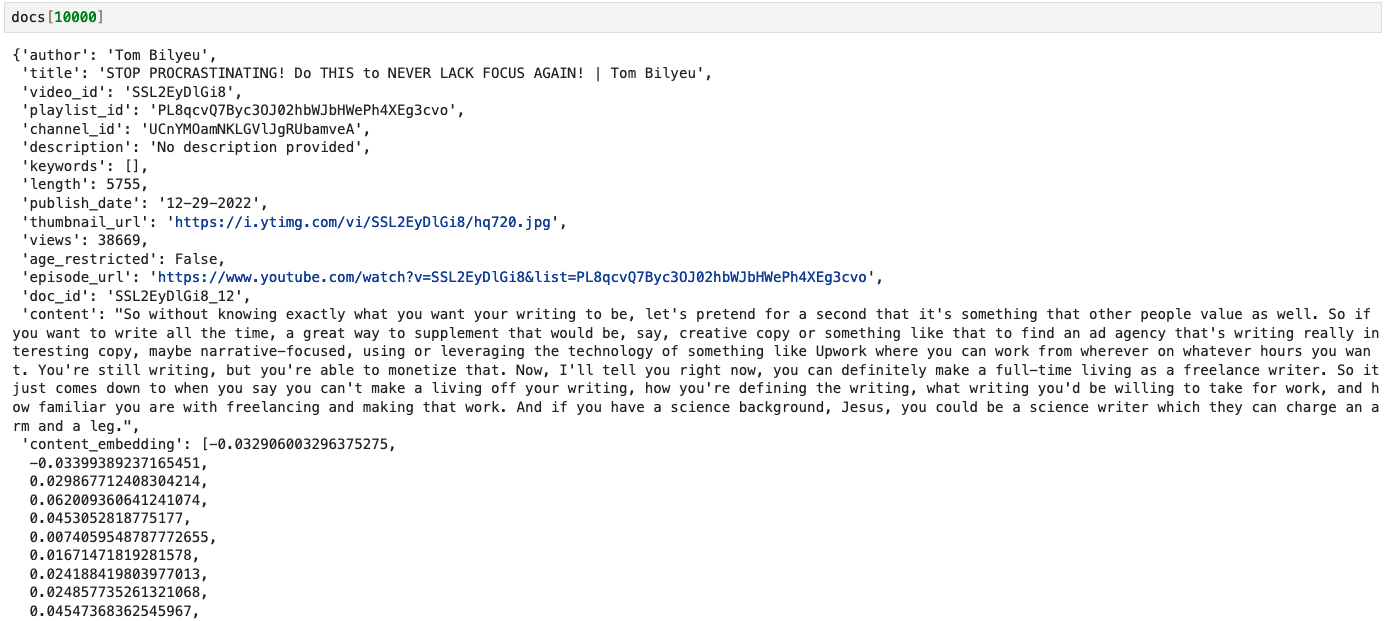)

In [22]:
def join_metadata(corpus: List[dict], 
                  text_vector_list: List[List[Tuple[str, np.array]]]
                 ) -> List[dict]:
    '''
    Combine episode metadata from original corpus with text/vectors tuples.
    Creates a new dictionary for each text/vector combination.
    '''

    joined_documents = []
    
    ########################
    # START YOUR CODE HERE #
    ########################
    
    return joined_documents

In [64]:
docs = join_metadata(None, None)

## Step 4 --> Save Your Hard Work!

We've reached the final step in our data preparation phase.  If you've made it this far, you should have 27,589 distinct documents (assuming a `chunk_size` of 256), and are now ready to index those documents on your **OpenSearch host/database**. Before moving on to the indexing step, we'll want to store our dataset on disk, and then complete one more task that will prove useful during week 2.

The FileIO Class is a convenient wrapper that makes it easy to save data to disk in either json or [parquet format](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705).  The choice is yours on which format to use, however, a note of caution: the json format will take up 3-4x more room on disk than parquet. In the example screenshot below, you can see that the json clocks in at 390Mb while the parquet is only 77Mb. If we were using a multi-GB dataset then I would definitely recommend parquet, but given the dataset sizes we'll be working with in this course, it won't make a huge difference. 

![json_example]( 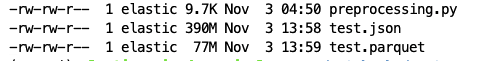)

Final note before saving: it's always a good idea to decide on a naming convention when saving out datasets, especially when the plan is to create multiple versions.  With that said, I suggest the following guidelines:
1. Name the dataset so it's easy to identify i.e. the name of the show: `impact-theory`
2. Hyphenate the name with the model used for text embeddings: `minilmL6`
3. Hyphenate the `chunk_size` you used for text chunking: `256`
4. If you really want to get specific you can also add a datetime suffix to the end, but that's up to you.

#### Example Naming Convention
`impact-theory-minilmL6-256.parquet`

In [43]:
#instantiate FileIO Class
io = FileIO()

#Define your output path
outpath = None

#save to disk
# io.save_as_parquet(file_path=outpath, data=docs, overwrite=False)

In [45]:
#Verify that you can reload data

# data_with_vectors = io.load_parquet(file_path=outpath)
# data_with_vectors[0]

# Assignment 1.4 - Create Datasets with Multiple Chunk Sizes

#### *Write a function that will loop through a list of chunk sizes and create a new dataset for each chunk size.*
#### INSTRUCTIONS

1. Fill in the rest of the code wherever you see **None**.  Use the functions you wrote in the previous assignments.
   **Caveat: The type hint for the returned output is None, so no need to change it.**
2. Also, be sure to pass the hard coded `gpt35_encoder` as the `SentenceSplitter` `tokenizer` arg in the below function.  👉 👉 👉 **THIS PART IS EXTREMELY IMPORTANT FOR OUTPUT STANDARDIZATION IN THIS COURSE!!!!** 👈 👈 👈


In [229]:

def create_datasets(chunk_sizes: List[int],
                    corpus: List[dict],
                    model: SentenceTransformer,
                    file_outpath_prefix: str='./impact-theory-minilmL6',
                    content_field: str='content',
                    device: str='cuda:0' if cuda.is_available() else 'cpu'
                    ) -> None:
    '''
    Given a raw corpus of data, this function loops through the sizes in chunk_sizes
    and creates a new dataset where each dataset doc contains episode metadata and it's 
    associated text chunk and vector representation. Output is directly saved to disk. 
    '''

    # DON'T CHANGE THIS LINE!!! IT'S HARD CODED FOR A REASON.
    encoding = tiktoken.encoding_for_model('gpt-3.5-turbo')
    gpt35_encoder = encoding.encode
    io = FileIO()
    
    for size in chunk_sizes:
        print(f'Creating dataset using chunk_size: {size}')
        start = time.perf_counter()
        ########################
        # START YOUR CODE HERE #
        ########################
        text_splitter = None
        content_splits = None
        text_vector_tuples = None
        joined_docs = None
        file_path = f'{file_outpath_prefix}-{None}.parquet'
        io.save_as_parquet(file_path=file_path, data=joined_docs, overwrite=False)
        end = time.perf_counter() - start
        print(f'Total Time to process dataset of chunk_size ({size}): {round(end/60, 2)} minutes')

In [62]:
chunks_sizes = [64, 128, 192]
file_outpath_prefix = 'impact-theory-minilmL6'

#Run this function when you're ready
# create_datasets(chunk_sizes, data, model, file_outpath_prefix)

# Conclusion

And that....is a wrap.  I realize this was a big notebook, with a lot of information thrown your way, my hope is that as you play around with different sentence chunking methods, creating embeddings, and comparing them, that the underlying concepts will start to sink in.  As always, if you come across roadblocks, be sure to ask any questions you have in the course Slack channel.  And don't lose those datasets!  We'll need them for the next phase in our journey: Indexing and Search!

## OPTIONAL: OpenAI Ada Embeddings

In [ ]:
#loads envars from predefined env file
from dotenv import load_dotenv
load_dotenv('./env_file', override=True)
import openai

In [ ]:
!curl -o tiktoken_fx.py https://raw.githubusercontent.com/americanthinker/vector_search_applications_PUBLIC/master/tiktoken_functions.py

In [23]:
from openai.embeddings_utils import get_embedding, cosine_similarity
from tiktoken_fx import Tokenizer
from math import ceil
import time

openai.api_key = os.environ['OPENAI_API_KEY']
model_type = "text-embedding-ada-002"
tokenizer_type="cl100k_base"

#https://openai.com/pricing
price_per_1000 = 0.0001

tokenizer = Tokenizer(price=price_per_1000, model_type=tokenizer_type)
total_tokens, cost = tokenizer.get_cost(splits)

Total Tokens: 6,295,583	Cost: $0.63


In [24]:
#https://platform.openai.com/account/rate-limits
tokens_per_minute = 1000000
total_batches = ceil(total_tokens/tokens_per_minute)
batch_size = ceil(len(splits)/total_batches)
batch_size

5287

#### Working around OpenAI rate limits

In [25]:
#split text_chunks into roughly 1 million tokens total per group
def check_batch_size_cost(text_chunks: List[str],
                          batch_size: int,
                          tokenizer: Tokenizer,
                          tokens_per_minute: int=1000000):
  total_cost = 0
  for num in range(0,len(text_chunks),batch_size):
      chunks = text_chunks[num:num+batch_size]
      total_tokens, cost = tokenizer.get_cost(chunks)
      total_cost += cost
      if total_tokens > tokens_per_minute:
        print('Batch size exceeds OpenAI rate limit')
  return total_cost

In [26]:
check_batch_size_cost(splits, batch_size, tokenizer)

Total Tokens: 903,299	Cost: $0.09
Total Tokens: 901,305	Cost: $0.09
Total Tokens: 905,671	Cost: $0.09
Total Tokens: 896,700	Cost: $0.09
Total Tokens: 903,199	Cost: $0.09
Total Tokens: 897,850	Cost: $0.09
Total Tokens: 887,559	Cost: $0.09


0.6295583

In [27]:
def get_openai_embeddings(model_type: str,
                          text_chunks: List[str],
                          batch_size: int,
                          requests_per_min: int=3000):
  if batch_size > requests_per_min:
    batch_size = requests_per_min
  embeddings = []
  num_minutes = ceil(len(text_chunks)/batch_size)
  print(f'This process will take at least {num_minutes} minutes due to OpenAI rate limits.')
  for num in range(0, len(text_chunks), batch_size):
    batch = text_chunks[num:num+batch_size]
    response = openai.Embedding.create(model=model_type, input=batch)
    batch_embeddings = [e['embedding'] for e in response['data']]
    embeddings.extend(batch_embeddings)
    print("Pausing for a minute between batches...")
    time.sleep(60)
  return embeddings

In [68]:
embs = get_openai_embeddings(model_type, splits[:100], batch_size)

This process will take at least 1 minutes due to OpenAI rate limits.
Pausing for a minute between batches...


<div>
    <img src="https://d1tlzifd8jdoy4.cloudfront.net/wp-content/uploads/2023/03/eyecatch-llamdaindex.png" width="200"/>
</div>

In [28]:
from llama_index import ServiceContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings import OpenAIEmbedding

In [29]:
embed_model = OpenAIEmbedding(embed_batch_size=150)
service_context = ServiceContext.from_defaults(embed_model=embed_model)

In [97]:
%%time
llama_embs = embed_model.get_text_embedding_batch(splits, show_progress=True)

Generating embeddings:   0%|          | 0/37007 [00:00<?, ?it/s]

CPU times: user 11.9 s, sys: 1.53 s, total: 13.5 s
Wall time: 6min 44s


In [30]:
embed_model.embed_batch_size

150

In [104]:
llama_df = pd.DataFrame({'text': splits, 'embeddings': llama_embs})

In [105]:
llama_df

text  \
0      I'm not an advocate for porn, but the one thin...   
1      I think there's a lot of things involved. I th...   
2      I think that's a really big problem for men. W...   
3      A lot of guys are not meeting that expectation...   
4      That's no longer being celebrated. Instead, it...   
...                                                  ...   
37002  And that's really my main focus, is to, you kn...   
37003  It's this ongoing pursuit. And the real way th...   
37004  It's hilarious. You have to hear it. It's an a...   
37005  I really appreciate it. Thank you. Thank you. ...   
37006  Not only does that help us build this communit...   

                                              embeddings  
0      [-0.03930378332734108, -0.001958907349035144, ...  
1      [-0.01497386023402214, -0.0033485570456832647,...  
2      [0.003110474906861782, -0.015326040796935558, ...  
3      [-0.016313627362251282, -0.019802747294306755,...  
4      [-0.024560874328017235, -0.01674359105527401, ...  
...                                                  ...  
37002  [-0.0013658697716891766, -0.000394923350540921...  
37003  [-0.019580287858843803, -0.00517278304323554, ...  
37004  [-0.017547881230711937, -0.031159311532974243,...  
37005  [-0.012008767575025558, -0.028076112270355225,...  
37006  [0.0221386905759573, -0.0023606554605066776, 0...  

[37007 rows x 2 columns]

In [107]:
df.to_parquet('./impact_theory_llama_embs.parquet', index=False)

In [108]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37007 entries, 0 to 37006
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   texts       37007 non-null  object
 1   embeddings  37007 non-null  object
dtypes: object(2)
memory usage: 464.0 MB


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37007 entries, 0 to 37006
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   texts       37007 non-null  object
 1   embeddings  37007 non-null  object
dtypes: object(2)
memory usage: 578.4+ KB
